In [11]:
from operator import itemgetter
import matplotlib. pyplot as plt
import matplotlib. ticker as ticker
import numpy as np
import pandas as pd
import pandas_profiling
import math
from io import StringIO 
from IPython.display import Image
import graphviz 
import pydotplus
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz

from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.datasets import *
from typing import Dict, Tuple
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
import seaborn as sns
import matplotlib. pyplot as plt
%matplotlib inline
sns. set(style="ticks")

In [12]:
diabetes = load_diabetes()
# Сформируем DataFrame
diabetes_df = pd.DataFrame(data=np.c_[diabetes['data']], columns=diabetes.feature_names)
diabetes_df['target'] = diabetes['target']

In [13]:
diabetes_df

age       sex       bmi        bp        s1        s2        s3  \
0    0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1   -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2    0.085299  0.050680  0.044451 -0.005671 -0.045599 -0.034194 -0.032356   
3   -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4    0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   
..        ...       ...       ...       ...       ...       ...       ...   
437  0.041708  0.050680  0.019662  0.059744 -0.005697 -0.002566 -0.028674   
438 -0.005515  0.050680 -0.015906 -0.067642  0.049341  0.079165 -0.028674   
439  0.041708  0.050680 -0.015906  0.017282 -0.037344 -0.013840 -0.024993   
440 -0.045472 -0.044642  0.039062  0.001215  0.016318  0.015283 -0.028674   
441 -0.045472 -0.044642 -0.073030 -0.081414  0.083740  0.027809  0.173816   

           s4        s5        s6  target  
0   -0.002592  0.019908 -0.017646   151.0  
1   -0.039493 -0.068330 -0.092204    75.0  
2   -0.002592  0.002864 -0.025930   141.0  
3    0.034309  0.022692 -0.009362   206.0  
4   -0.002592 -0.031991 -0.046641   135.0  
..        ...       ...       ...     ...  
437 -0.002592  0.031193  0.007207   178.0  
438  0.034309 -0.018118  0.044485   104.0  
439 -0.011080 -0.046879  0.015491   132.0  
440  0.026560  0.044528 -0.025930   220.0  
441 -0.039493 -0.004220  0.003064    57.0  

[442 rows x 11 columns]

In [14]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  target  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB


<AxesSubplot:>

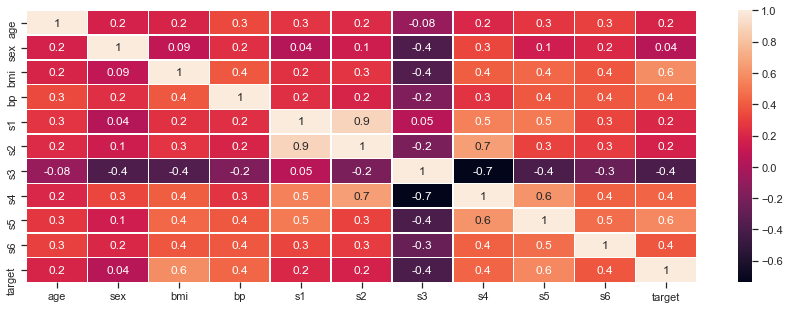

In [15]:
fig, ax = plt.subplots(figsize=(15,5)) 
sns.heatmap(diabetes_df.corr(), annot = True, fmt='.1g', linewidths=.5, ax=ax)

<AxesSubplot:xlabel='s5', ylabel='target'>

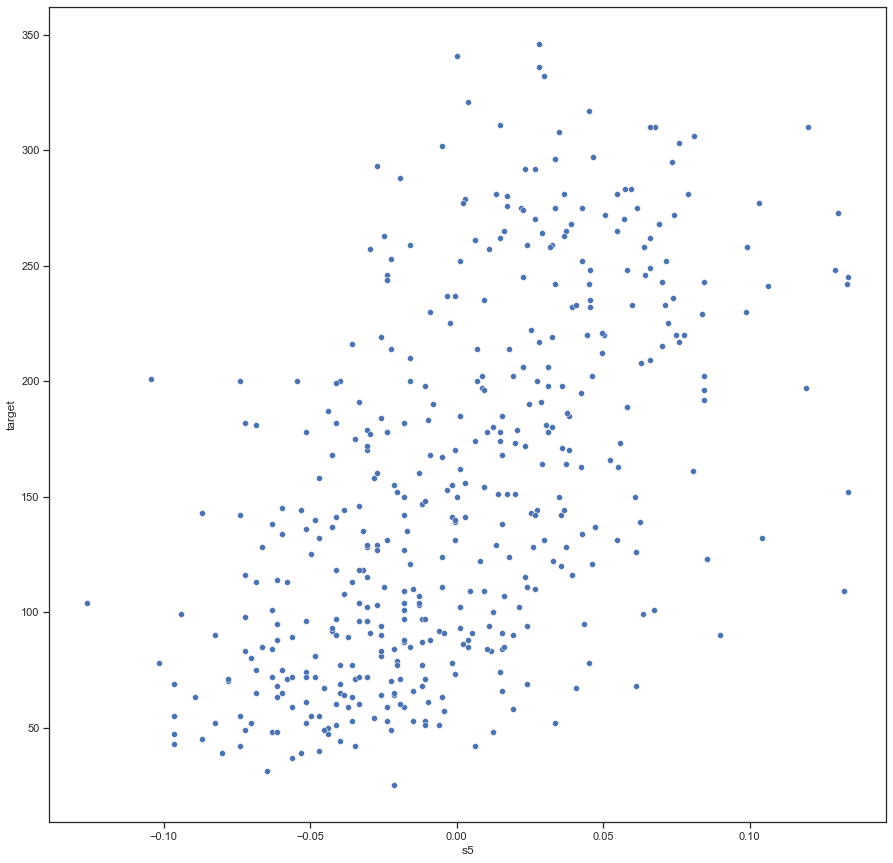

In [16]:
fig, ax = plt.subplots(figsize=(15,15)) 
sns.scatterplot(data=diabetes_df, x="s5", y="target", ax=ax)

# Аналитическое восстановление зависимости

In [17]:
x_array = diabetes_df['s5'].values
y_array  = diabetes_df['target'].values

In [18]:
# Аналитическое вычисление коэффициентов регрессии
def analytic_regr_coef(x_array : np.ndarray, 
                       y_array : np.ndarray) -> Tuple[float, float]:
    x_mean = np.mean(x_array)
    y_mean = np.mean(y_array)
    var1 = np.sum([(x-x_mean)**2 for x in x_array])
    cov1 = np.sum([(x-x_mean)*(y-y_mean) for x, y in zip(x_array, y_array)])
    b1 = cov1 / var1
    b0 = y_mean - b1*x_mean
    return b0, b1

In [19]:
b0, b1 = analytic_regr_coef(x_array, y_array)
b0, b1

(152.13348416289628, 916.1387228150982)

In [20]:
# Вычисление значений y на основе x для регрессии
def y_regr(x_array : np.ndarray, b0: float, b1: float) -> np.ndarray:
    res = [b1*x+b0 for x in x_array]
    return res

In [21]:
y_array_regr = y_regr(x_array, b0, b1)

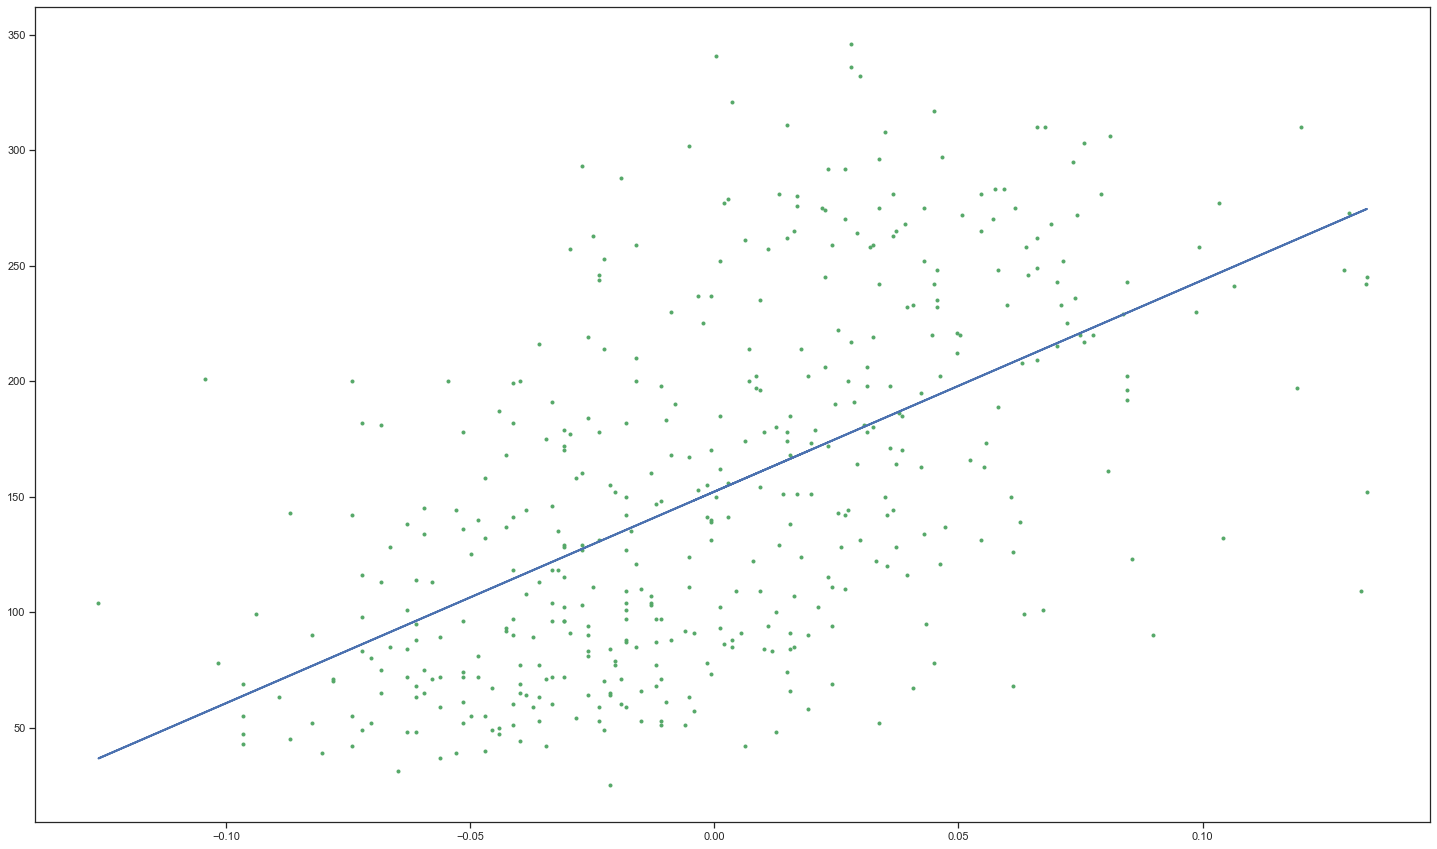

In [22]:
fig, ax = plt.subplots(figsize=(25,15)) 
ax.plot(x_array, y_array, 'g.')
ax.plot(x_array, y_array_regr, 'b', linewidth=2.0)
plt.show()

# Простейшая реализация градиентного спуска

In [23]:
# Простейшая реализация градиентного спуска
def gradient_descent(x_array : np.ndarray,
                     y_array : np.ndarray,
                     b0_0 : float,
                     b1_0 : float,
                     epochs : int,
                     learning_rate : float = 0.001
                    ) -> Tuple[float, float]:
    # Значения для коэффициентов по умолчанию
    b0, b1 = b0_0, b1_0
    k = float(len(x_array))
    for i in range(epochs): 
        # Вычисление новых предсказанных значений
        # используется векторизованное умножение и сложение для вектора и константы
        y_pred = b1 * x_array + b0
        # Расчет градиентов
        # np.multiply - поэлементное умножение векторов
        dL_db1 = (-2/k) * np.sum(np.multiply(x_array, (y_array - y_pred)))
        dL_db0 = (-2/k) * np.sum(y_array - y_pred)
        # Изменение значений коэффициентов:
        b1 = b1 - learning_rate * dL_db1
        b0 = b0 - learning_rate * dL_db0
    # Результирующие значения
    y_pred = b1 * x_array + b0
    return b0, b1, y_pred

In [24]:
def show_gradient_descent(epochs, b0_0, b1_0):
    grad_b0, grad_b1, grad_y_pred = gradient_descent(x_array, y_array, b0_0, b1_0, epochs)
    print('b0 = {} - (теоретический), {} - (градиентный спуск)'.format(b0, grad_b0))
    print('b1 = {} - (теоретический), {} - (градиентный спуск)'.format(b1, grad_b1))
    print('MSE = {}'.format(mean_squared_error(y_array_regr, grad_y_pred)))
    plt.plot(x_array, y_array, 'g.')
    plt.plot(x_array, y_array_regr, 'b', linewidth=2.0)
    plt.plot(x_array, grad_y_pred, 'r', linewidth=2.0)
    plt.show()

b0 = 152.13348416289628 - (теоретический), 27.602064145556668 - (градиентный спуск)
b1 = 916.1387228150982 - (теоретический), 0.4144495722401128 - (градиентный спуск)
MSE = 17405.248654354575


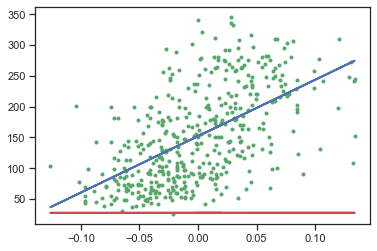

In [25]:
show_gradient_descent(100, 0, 0)

b0 = 152.13348416289628 - (теоретический), 131.58564777628425 - (градиентный спуск)
b1 = 916.1387228150982 - (теоретический), 4.136068764083715 - (градиентный спуск)
MSE = 2303.9982883071652


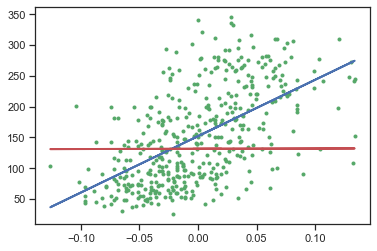

In [26]:
show_gradient_descent(1000, 0, 0)

b0 = 152.13348416289628 - (теоретический), 152.133484162889 - (градиентный спуск)
b1 = 916.1387228150982 - (теоретический), 397.0397144945702 - (градиентный спуск)
MSE = 609.6465620800684


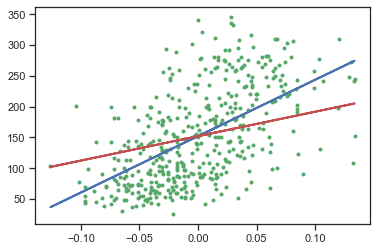

In [27]:
show_gradient_descent(100000, 0, 100)

b0 = 152.13348416289628 - (теоретический), 152.13348416288918 - (градиентный спуск)
b1 = 916.1387228150982 - (теоретический), 906.2116000713277 - (градиентный спуск)
MSE = 0.22295874653823025


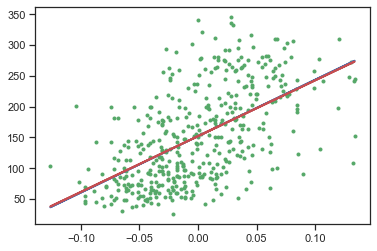

In [28]:
show_gradient_descent(1000000, 0, 0)

b0 = 152.13348416289628 - (теоретический), 152.13348416288923 - (градиентный спуск)
b1 = 916.1387228150982 - (теоретический), 969.4780689412231 - (градиентный спуск)
MSE = 6.436845803536035


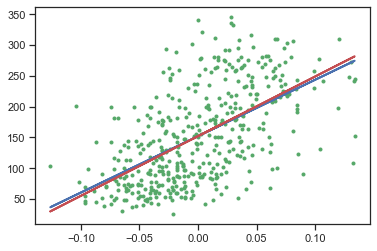

In [29]:
show_gradient_descent(100000, 0, 1000)

# 1. Линейная модель

In [30]:
x_array_res = x_array.reshape(-1,1)
y_array_res  = y_array.reshape(-1,1)

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import *

In [32]:
linear = LinearRegression()
l = linear.fit(x_array_res, y_array_res)
(b1, l.coef_), (b0, l.intercept_)

((916.1387228150982, array([[916.13872282]])),
 (152.13348416289628, array([152.13348416])))

# Lasso

In [33]:
reg3 = Lasso().fit(x_array.reshape(-1, 1), y_array)
(b1, reg3.coef_), (b0, reg3.intercept_)

((916.1387228150982, array([474.13872282])),
 (152.13348416289628, 152.1334841628961))

In [34]:
reg4 = Ridge().fit(x_array.reshape(-1, 1), y_array)
(b1, reg4.coef_), (b0, reg4.intercept_)

((916.1387228150982, array([458.06936141])),
 (152.13348416289628, 152.1334841628961))

In [35]:
reg5 = ElasticNet().fit(x_array.reshape(-1, 1), y_array)
(b1, reg5.coef_), (b0, reg5.intercept_)

((916.1387228150982, array([3.13125551])),
 (152.13348416289628, 152.13348416289594))

# SVR

<AxesSubplot:xlabel='s5', ylabel='target'>

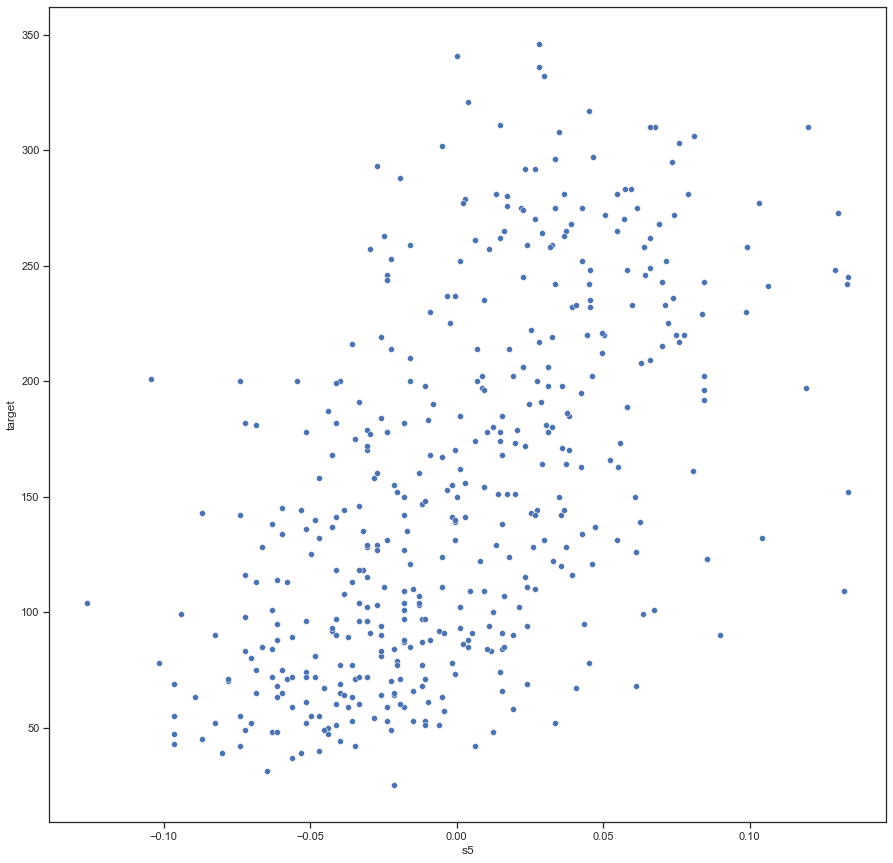

In [36]:
fig, ax = plt.subplots(figsize=(15,15)) 
sns.scatterplot(data=diabetes_df, x="s5", y="target", ax=ax)

In [37]:
def plot_regr(clf, x, y):
    title = clf.__repr__
    clf.fit(x.reshape(-1, 1), y)
    boston_y_pred = clf.predict(x.reshape(-1, 1))
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_title(title)
    ax.plot(x, y, 'b.')
    ax.plot(x, boston_y_pred, 'ro')
    plt.show()

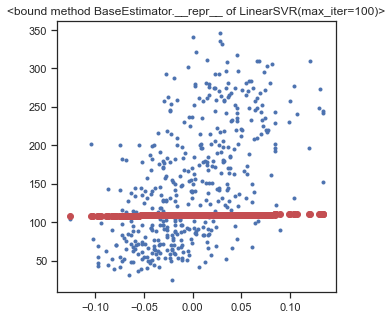

In [38]:
plot_regr(LinearSVR(C=1.0, max_iter=100), x_array, y_array)

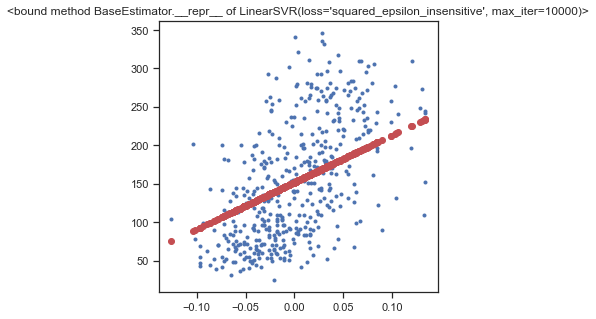

In [39]:
plot_regr(LinearSVR(C=1.0, loss='squared_epsilon_insensitive', max_iter=10000), x_array, y_array)

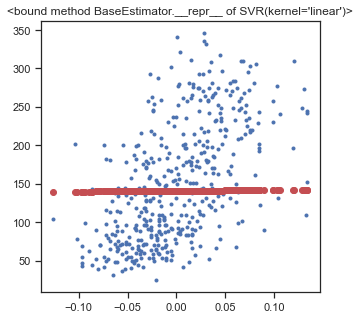

In [40]:
plot_regr(SVR(kernel='linear', C=1.0), x_array, y_array)

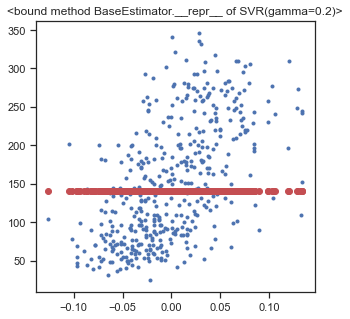

In [41]:
plot_regr(SVR(kernel='rbf', gamma=0.2, C=1.0), x_array, y_array)

# SVC

In [42]:
wine = load_iris()
winex = wine.data[:, :2]
winey = wine.target

In [43]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    #Можно проверить все ли метки классов предсказываются
    #print(np.unique(Z))
    out = ax.contourf(xx, yy, Z, **params)
    return out


def plot_cl(clf, x, y):
    title = clf.__repr__
    clf.fit(x, y)
    fig, ax = plt.subplots(figsize=(5,5))
    X0= x[:, 0]
    X1 = y
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    plt.show()

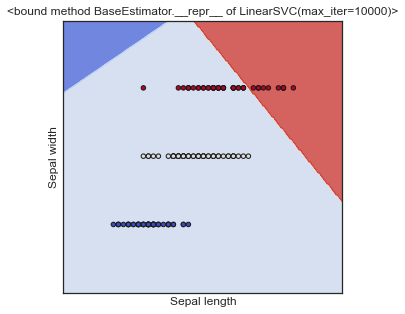

In [44]:
plot_cl(LinearSVC(C=1.0, max_iter=10000), winex, winey)

# Деревья

In [45]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

## DecisionTreeClassifier

In [46]:
# Разделим выборку на обучающую и тестовую
wine_X_train, wine_X_test, wine_y_train, wine_y_test = train_test_split(
    wine.data, wine.target, test_size=0.3, random_state=1)
wine_X_train.shape, wine_X_test.shape

((105, 4), (45, 4))

In [47]:
wine_tree_cl_feat_1 = DecisionTreeClassifier(random_state=1).fit(wine_X_train, wine_y_train)
wine_y_test_predict = wine_tree_cl_feat_1.predict(wine_X_test)
wine_y_test_predict.shape

(45,)

In [48]:
# Проверим точность по классам
print_accuracy_score_for_classes(wine_y_test, wine_y_test_predict)

Метка 	 Accuracy
0 	 1.0
1 	 0.9444444444444444
2 	 0.9230769230769231


In [49]:
# Визуализация дерева
def get_png_tree(tree_model_param, feature_names_param):
    dot_data = StringIO()
    export_graphviz(tree_model_param, out_file=dot_data, feature_names=feature_names_param,
                    filled=True, rounded=True, special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph.create_png()

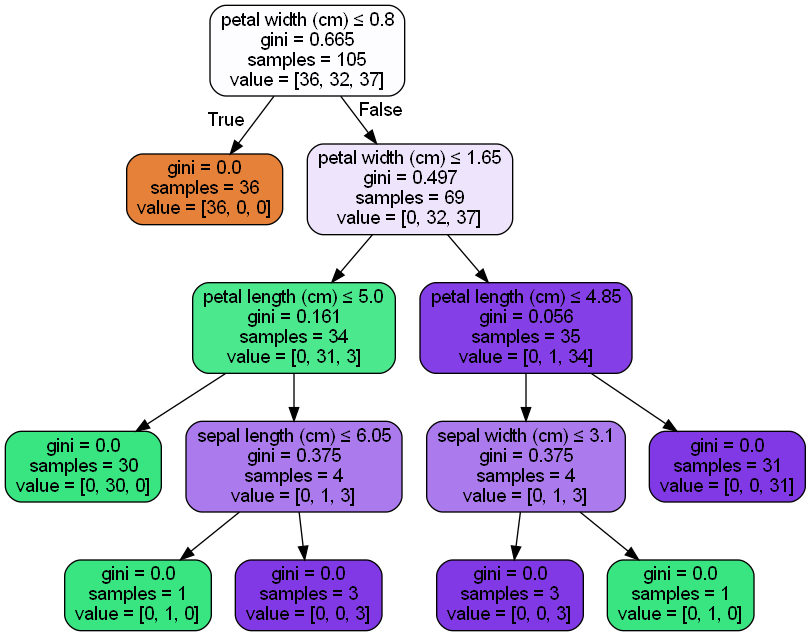

In [50]:
Image(get_png_tree(wine_tree_cl_feat_1, wine.feature_names), height='70%')

## DecisionTreeRegressor

In [51]:
# Разделим выборку на обучающую и тестовую
diabetes_X_train, diabetes_X_test, diabetes_y_train, diabetes_y_test = train_test_split(
    diabetes.data, diabetes.target, test_size=0.25, random_state=1)
diabetes_X_train.shape, diabetes_X_test.shape

((331, 10), (111, 10))

In [52]:
diabetes_tree_regr = DecisionTreeRegressor(random_state=1)
diabetes_tree_regr.fit(diabetes_X_train, diabetes_y_train)
done = diabetes_tree_regr.predict(diabetes_X_test)

In [53]:
diabetes.feature_names

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

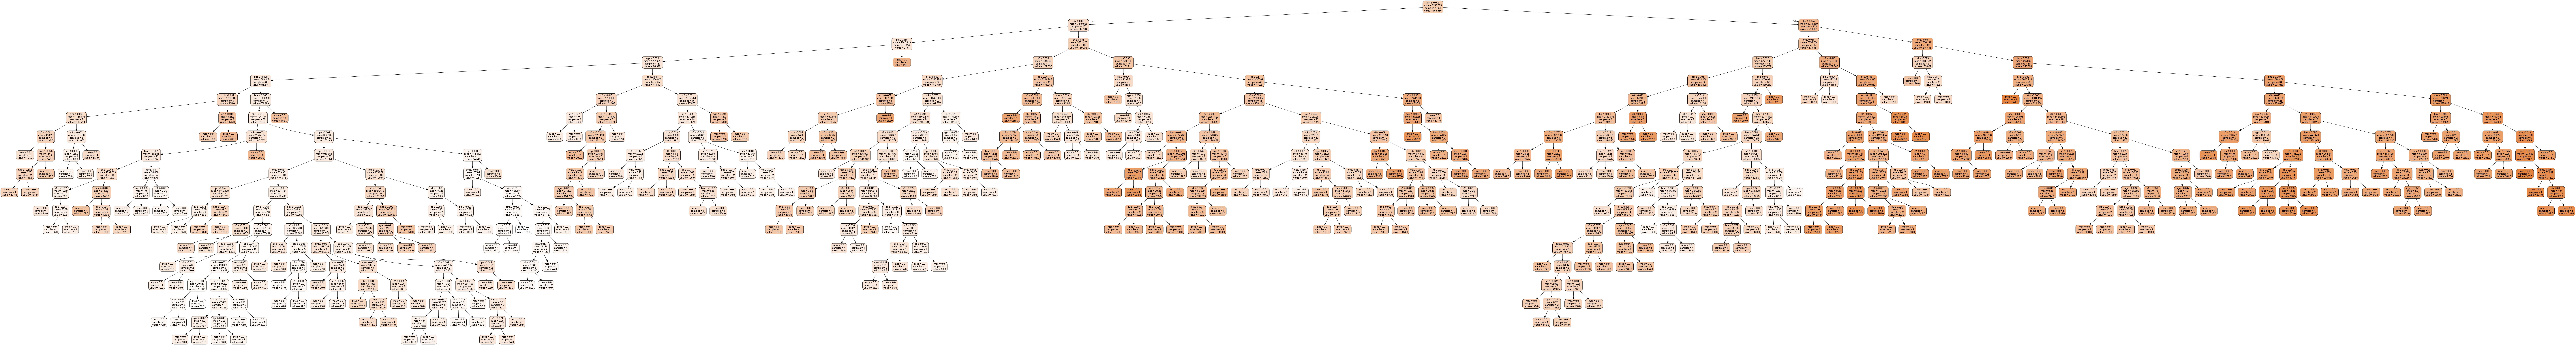

In [54]:
Image(get_png_tree(diabetes_tree_regr, diabetes.feature_names), height='70%')